# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import style
import math

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=InterpolationWarning)

In [5]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
plt.style.use('seaborn-v0_8')

# Helper Functions

In [7]:
def compare_item(item_code_1,item_code_2):
    '''This functions shows the descriptive information about the two comparing items.'''
    
    for c in o_col:
        if c not in ['PER_TAG','date']:
            print(c+':\t\t',df[df['ITEM_CODE']==item_code_1][c].unique(),df[df['ITEM_CODE']==item_code_2][c].unique())
            

In [8]:
def plot_timeseries(item,date,retailer):
    '''Plots trendline for given item and mentioned retailer.'''
    
    y=df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)]['VOLUME'].values
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y,'o-',color='green')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume across the time for {}'.format(item),fontsize=20)
    plt.show()

In [9]:
def plot_corr(segment,retailer,annot=True):
    '''This functions plots the correlation heatmap for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    plt.figure(figsize=(15,12))
    sns.heatmap(dummy.corr(),annot=annot)
    plt.show()
    
def get_corr(df,segment,retailer):
    '''This functions shows the correlation coefficient values for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    
    return dummy.corr()

In [10]:
def get_highest(correlation_dataframe,correlation_value):
    '''This function returns the multi indexed dataframe showing items having highest correlation value'''
    
    New=pd.DataFrame()
    if correlation_dataframe.shape[1]>1:
        for col in correlation_dataframe.columns:
            item_1=[col]*correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].shape[0]
            item_2=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].index)
            item_1=[int(x) if type(x)==int else str(x) for x in item_1]
            item_2=[int(x) if type(x)==int else str(x) for x in item_2]
            corr=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].values)
            T=pd.DataFrame({'Item_1':item_1,
                           'Item_2':item_2,
                           'Corr':corr})
            T['Corr']=T['Corr'].apply(lambda x:x[0])
            New=pd.concat([New,T],ignore_index=True)
    else:
        T=pd.DataFrame({'Item_1':correlation_dataframe.index,
                           'Item_2':correlation_dataframe.columns,
                           'Corr':correlation_dataframe.iloc[0,0]})
        #T['Corr']=T['Corr'].apply(lambda x:x[0])
        New=pd.concat([New,T],ignore_index=True)
    
    New.set_index(["Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return New

In [11]:
def segment_wise_correlation(dataframe,retailer,corr_value):
    '''This functions returns the multi indexed dataframe containing items with high correlation value for 
    all the segments of a dataframe.'''
    
    
    T=pd.DataFrame()
    for seg in dataframe[dataframe['RETAILER']==retailer]['SEGMENT'].unique():
        New=get_highest(get_corr(seg,retailer),corr_value)
        New.reset_index(inplace=True)
        New['SEGMENT']=[seg]*New.shape[0]
        T=pd.concat([T,New],ignore_index=True)
    T.set_index(["SEGMENT","Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return T

In [12]:
def correlated_items_dataframe(df,item,segment,retailer,corr_value):
    '''This function returns dataframe containing Volume Sales of given correlated items.'''
    
    item_list=[int(x) for x in get_highest(get_corr(df,segment,retailer),corr_value).loc[item,:].index]
    N=pd.DataFrame()
    T=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
    T.reset_index(inplace=True,drop=True)
    T=T.rename(columns={T.columns[0]: item})
    if len(item_list)>1:
        for item in item_list:
            N=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
            N.reset_index(inplace=True,drop=True)
            N=N.rename(columns={N.columns[0]: item})
            T=pd.concat([T,N],axis=1)
    T.set_index(df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['date'].values,inplace=True)
    
    return T

In [13]:
def plot_correlated_trendlines(T,date):
    '''This function plots trendlines of given correlated items.'''
    
    item2_list=[int(col) for col in T.columns[1:-3]]
    y1=T[T.columns[0]]
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y1,'o-')
    leg=[T.columns[0]]
    
    for y in item2_list:
        ax.plot(x,T[[y]].values,'o-')
        leg.append(y)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume Trend across Time ',fontsize=20)
    plt.legend(leg)
    plt.show()

In [14]:
def plot_correlated_trendlines_separately(dataframe):
    '''This function plots trendlines of highly correlated items separately.'''
    
    fig, axes = plt.subplots(nrows=dataframe.shape[1], ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        y=dataframe[dataframe.columns[i]]
        x=date
        if i==0:
            ax.plot(x,y,'.-',color='red' ,linewidth=0.4)
        else:
            ax.plot(x,y,'.-' ,linewidth=0.4)
        ax.set_title(dataframe.columns[i])
        plt.xticks(rotation=90,fontsize=14)
        #plt.xlabel('Dates',fontsize=20)
        plt.yticks(rotation=0,fontsize=14)
        #plt.ylabel(str(item),fontsize=14)
        ax.xaxis_date()     # interpret the x-axis values as dates
        fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
        #plt.grid(True)
        #plt.title('Volume Sales for {}'.format(item),fontsize=20)
        #ax.xaxis.set_ticks_position(None)
        #ax.yaxis.set_ticks_position(None)
        #ax.spines['Top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

In [15]:
def ADF_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series contains a unit root, it is not stationary.
       Alternative Hypothesis: There is no unit root.
       
       Low p-values are preferable. If the test returns a p-value BELOW the chosen significance level (e.g.0.05),
       we reject the null and conclude that the series does not contain a unit root.It appears to be stationary.
       '''
    adf_test = adfuller(x, autolag="aic")
    t_stat, p_value, _, _, _, _  = adf_test
    conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
    res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
    return res_dict

In [16]:
def KPSS_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series is stationary around a deterministic trend (trend-stationary)
       Alternative Hypothesis: The series has a unit root. It is non-stationary.
       
       High p-values are preferable. If the test returns a p-value ABOVE the chosen significance level (e.g.0.05),
       we conclude that the series appears to be atleast trend stationary.
       
    '''
    kpss_test = kpss(x)
    t_stat, p_value, _, critical_values  = kpss_test
    conclusion = "stationary" if p_value > ALPHA else "not stationary"
    res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
    return res_dict

In [17]:
def plot_stationarity(time_series, lags,model):
    
    y=time_series
    # decompose the time series into trend, seasonality and residuals
    decomp = seasonal_decompose(time_series, 
                                   model=model, 
                                   period=lags)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))
    y.plot(ax=ax1)
    #ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title(y.name)
    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")
    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);
    plt.tight_layout()

In [18]:
def get_segment(df,segment,retailer,date):
    try:
        item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()[0]
    except:
        item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()
    T=correlated_items_dataframe(df,item,segment,retailer,0)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [19]:
def get_items_from_segment(item,segment,retailer,date,corr_value=0.8):
    T=correlated_items_dataframe(item,segment,retailer,corr_value)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    #T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [20]:
def plot_timeseries_segment(dataframe,segment):
    x=get_dates(dataframe)
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,dataframe[segment].values,'o-',color='blue',linewidth=2.15)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('{} volume across the time'.format(segment),fontsize=20)
    plt.show()

In [21]:
def get_dates(dataframe):
    date=dataframe
    date.reset_index(inplace=True,drop=True)
    date=pd.to_datetime(date['date'])
    return date

In [22]:
def check_stationarity(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns[:-3]:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

In [23]:
def check_stationarity3(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

In [24]:
def check_stationarity2(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    
    
    return N

In [25]:
def inverse_differencing(item,n_diff,n_sdiff):
    n_sdiff=52*n_sdiff
    k=pd.concat([other_car[[item]],stat1[[item]]],axis=1,ignore_index=False)
    k.columns=['Actual','Differenced']
    k['D']=(k['Actual'].diff(n_diff)-k['Actual'].diff(n_diff).shift(n_sdiff))
    k['Inversed']=k['D']+k['Actual'].diff(n_diff).shift(n_sdiff)
    k['Inversed'].iloc[:n_sdiff]=k['Actual'].diff(n_diff).iloc[:n_sdiff]
    k['Inversed'].iloc[:n_diff]=k['Actual'].iloc[:n_diff]
    k['Inversed'].iloc[n_diff:]=k['Inversed'].iloc[n_diff:]+k['Actual'].shift(n_diff).iloc[n_diff:]
    k.drop('D',inplace=True,axis=1)
    
    return k

In [26]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def WAPE(y_true, y_pred, weighting = 'non-zero-flag'):
    w = {'non-zero-flag':np.where(y_true == 0, 0, 1), 
         'y':y_true,
        }.get(weighting)
    return mean_absolute_percentage_error(y_true, y_pred, w)

def TAPE(y_true, y_pred):
    total = np.sum(np.abs(y_true))
    pe = (y_pred - y_true)/total
    return np.sum(np.abs(pe)) if total > 0 else np.inf

def adj_PE(y_true, y_pred):
    return (y_pred - y_true)/(y_true + 1)

def PE(y_true, y_pred):
    return y_pred/y_true - 1

# Reading the data & Classifying Features

In [27]:
df=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\DF_dataframe_final.csv')

##### Creating a dictionary containing description about the particular item

In [28]:
item_detail={}
for man in df['MANUFACTURER'].unique():
    for item in df[df['MANUFACTURER']==man]['ITEM_CODE'].unique():
        item_detail[item]=df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique()
        #print(item,df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique())

In [29]:
item_detail[12844090321]

array(['Refresh Your Car Dual Scent Paper New Car And Cool Breeze 2s'],
      dtype=object)

##### Creating a list containing names for all the object type columns

In [30]:
o_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='O':
        o_col.append(c)

##### Creating a list containing names for all the integer type columns

In [31]:
i_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='int':
        i_col.append(c)

In [32]:
print(i_col,sep=' ')

[]


##### Creating a list containing names for all the float type columns

In [33]:
f_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='float':
        f_col.append(c)

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [34]:
rem_f_col=[]
for i in f_col[:-117]:
    if df[i].describe()['std']==0 and df[i].describe()['mean']==0:
        rem_f_col.append(i)
        

##### Creating a list containing names for all the columns which contains SINE values

In [35]:
sine_col=f_col[-117:]

##### Removing all the selected columns

In [36]:
f_col=[ele for ele in f_col if ele not in rem_f_col+sine_col]

##### Creating a list containing names of all the columns to be removed which are have more than 95% as ZERO values

In [37]:
zero_col=[]
for col in f_col:
    if df.shape[0]*0.95<=df[df[col]==0].shape[0]:
        zero_col.append(col)
        #print(col,df[df[col]==0].shape[0])

##### Removing all the selected columns

In [38]:
f_col=[ele for ele in f_col if ele not in zero_col]

In [39]:
o_col=[ele for ele in o_col if ele not in ['WEEK_END_DATE', 'WEEK_END_DATE_New']]

##### Date Timeline

In [40]:
# We can take any SKU and obtain its index to get date timeline.
date=get_dates(df[(df['ITEM_CODE']==9300701525033)&(df['RETAILER']=='Woolworths')][['date']])

---------
# Dealing only with ONGOING SKUs:

- Reading the data containnig information about ongoing SKUs.
- Converting and extracting the dataset of ongoing items.
- Running Stationarity Test.
- Implementing the suggestion from Test Results.
- Validating Stationarity by running stationarity test again.
- Splitting the dataset into Train and Test (for both, stationary and original timeseries)


In [41]:
# Reading the dataset
ongoing=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\EDA\Classified TimeSeries\Ongoing.csv',index_col='Unnamed: 0')

In [42]:
ongoing.head()

,RETAILER,SEGMENT,ITEM,STATUS
0,Woolworths,Other Car,12844067194,Ongoing
1,Woolworths,Other Car,12844082043,Ongoing
4,Woolworths,Other Car,12844090314,Ongoing
5,Woolworths,Other Car,12844090321,Ongoing
7,Woolworths,Other Car,12844092035,Ongoing


In [43]:
# Extracting data of ongoing items from original large Dataframe
D=pd.DataFrame()
for i in ongoing.index:
    D=pd.concat([D,df[(df['ITEM_CODE']==ongoing['ITEM'].loc[i])&(df['RETAILER']==ongoing['RETAILER'].loc[i])]],
                axis=0,ignore_index=False)
                 

In [44]:
df1=D.copy()

In [45]:
df1[['ITEM_CODE','SEGMENT','RETAILER','VOLUME','date']].head()

,ITEM_CODE,SEGMENT,RETAILER,VOLUME,date
0,12844067194,Other Car,Woolworths,20732.000,2019-04-07
1,12844067194,Other Car,Woolworths,18034.000,2019-04-14
2,12844067194,Other Car,Woolworths,18105.000,2019-04-21
3,12844067194,Other Car,Woolworths,17821.000,2019-04-28
4,12844067194,Other Car,Woolworths,17040.000,2019-05-05


In [46]:
# Running KPSS and ADF Tests for the timeseries of all the Ongoing SKUs, to check Stationarity
A=pd.DataFrame()
for segment in df1['SEGMENT'].unique():
    for retailer in df1[df1['SEGMENT']==segment]['RETAILER'].unique():
        T=check_stationarity(get_segment(df1,segment,retailer,date))
        diff_stat=[]
        tr_stat=[]
        non_stat=[]
        stationary=[]
        for item in T.index.levels[0]:
            if (T.loc[item,'Conclusion']['ADF']=='stationary') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Trend Stationary'.format(item,retailer))
                tr_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='stationary'):
                #print('{} in {} is Difference Stationary'.format(item,retailer))
                diff_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Non Stationary'.format(item,retailer))
                non_stat.append(item)
            else:
                stationary.append(item)
            
        a=pd.DataFrame({'RETAILER':[retailer]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'SEGMENT':[segment]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'ITEM':tr_stat+diff_stat+non_stat+stationary,
          'TREND STATIONARY':['Yes' if item in tr_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'DIFF. STATIONARY':['Yes' if item in diff_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'NON STATIONARY':['Yes' if item in non_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'STATIONARY':['Yes' if item in stationary else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)]
          })
        A=pd.concat([A,a],ignore_index=True,axis=0)

In [47]:
A.head()

,RETAILER,SEGMENT,ITEM,TREND STATIONARY,DIFF. STATIONARY,NON STATIONARY,STATIONARY
0,Woolworths,Other Car,12844082043,Yes,No,No,No
1,Woolworths,Other Car,76171520319,No,Yes,No,No
2,Woolworths,Other Car,9312790523371,No,Yes,No,No
3,Woolworths,Other Car,9312790523388,No,Yes,No,No
4,Woolworths,Other Car,76171178558,No,No,Yes,No


In [48]:
# Dropping the irrelevant rows and converting SKUs to int from object
A=A[~(A['SEGMENT']==A['ITEM'])]
A['ITEM']=A['ITEM'].apply(lambda x:int(x))

In [49]:
print("Total Ongoing Items: ",A.shape[0])
print("Non Stationary Ongoing Items: ",(A[A['TREND STATIONARY']=='Yes'].shape[0]+A[A['DIFF. STATIONARY']=='Yes'].shape[0]+A[A['NON STATIONARY']=='Yes'].shape[0]))
print("Stationary Ongoing Items: ",(A[A['STATIONARY']=='Yes'].shape[0]))
      

Total Ongoing Items:  238
Non Stationary Ongoing Items:  91
Stationary Ongoing Items:  147


-------

# Forecasting for Items using VARMAX model

- Make timeseries Stationary by differencing or detrending.
- Perform same operation on the entire dataset. (To make all the timeseries come on same timeline.)
- Run the Granger Causality Test and Select the Endogenous and Exogenous Variables.
- Create a VARMAX model.
- Plot the residuals and diagonostic checking.
- Forecasting and Error Metrics.

### Making Timeseries Stationary by Differencing

- We are performing first order differencing on the entire dataset.
- Then running Stationary Tests (ADF and KPSS).

In [50]:
# Running KPSS and ADF Tests for the timeseries of all the Ongoing SKUs, to check Stationarity
A=pd.DataFrame()
for segment in df1['SEGMENT'].unique():
    for retailer in df1[df1['SEGMENT']==segment]['RETAILER'].unique():
        T=check_stationarity(get_segment(df1,segment,retailer,date).diff(1).dropna()) # Performing first order differencing 
        diff_stat=[]
        tr_stat=[]
        non_stat=[]
        stationary=[]
        for item in T.index.levels[0]:
            if (T.loc[item,'Conclusion']['ADF']=='stationary') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Trend Stationary'.format(item,retailer))
                tr_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='stationary'):
                #print('{} in {} is Difference Stationary'.format(item,retailer))
                diff_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Non Stationary'.format(item,retailer))
                non_stat.append(item)
            else:
                stationary.append(item)
            
        a=pd.DataFrame({'RETAILER':[retailer]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'SEGMENT':[segment]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'ITEM':tr_stat+diff_stat+non_stat+stationary,
          'TREND STATIONARY':['Yes' if item in tr_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'DIFF. STATIONARY':['Yes' if item in diff_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'NON STATIONARY':['Yes' if item in non_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'STATIONARY':['Yes' if item in stationary else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)]
          })
        A=pd.concat([A,a],ignore_index=True,axis=0)

In [51]:
# Dropping the irrelevant rows and converting SKUs to int from object
A=A[~(A['SEGMENT']==A['ITEM'])]
A['ITEM']=A['ITEM'].apply(lambda x:int(x))

In [52]:
print("Total Ongoing Items: ",A.shape[0])
print("Non Stationary Ongoing Items: ",(A[A['TREND STATIONARY']=='Yes'].shape[0]+A[A['DIFF. STATIONARY']=='Yes'].shape[0]+A[A['NON STATIONARY']=='Yes'].shape[0]))
print("Stationary Ongoing Items: ",(A[A['STATIONARY']=='Yes'].shape[0]))
      

Total Ongoing Items:  238
Non Stationary Ongoing Items:  13
Stationary Ongoing Items:  225


#### Extracting Volume Sales for all the SKUs and Performing Differencing
----

- Our VARMAX model uses the non differenced dataset, therefore below here I am trying to create a dataframe containing the VOLUME sales for each $ongoing$ SKU.
- In the next cell, splitting the dataset into train and test.
    - Last 8 values are being used in test dataset.

In [53]:
F=pd.DataFrame()
D=pd.DataFrame()
for segment in A['SEGMENT'].unique():
    for retailer in A['RETAILER'].unique():
        if A[(A['SEGMENT']==segment)&(A['RETAILER']==retailer)].shape[0]!=0:
            D=get_segment(df1,segment,retailer,date)
            D.drop(D.columns[-4:],axis=1,inplace=True)
            D.columns=[str(x)+'_WW' if retailer in ['Woolworths'] else str(x)+'_CG' for x in D.columns]
            F=pd.concat([F,D],axis=1,ignore_index=False)
        else:
            pass

In [54]:
# Splitting into Train and Test
test_set=F.iloc[-8:,:]
train_set=F.iloc[:-8,:]
print("Dataset Shape: ",F.shape)
print("Train Set Shape: {}".format(train_set.shape))
print("Test Set Shape: {}".format(test_set.shape))

Dataset Shape:  (118, 238)
Train Set Shape: (110, 238)
Test Set Shape: (8, 238)


- To run the $Granger Causality Test$ we need stationary timeseries. Therefore, I am creating a dataframe containing stationary timeseries (Here, by means of first order differencing).
- In the next cell, splitting the dataset into train and test. This is done so that while running $Granger Causality Test$, test dataset is not present. 
    - Last 8 values are being used in test dataset.

In [55]:
F=pd.DataFrame()
D=pd.DataFrame()
for segment in A['SEGMENT'].unique():
    for retailer in A['RETAILER'].unique():
        if A[(A['SEGMENT']==segment)&(A['RETAILER']==retailer)].shape[0]!=0:
            D=get_segment(df1,segment,retailer,date).diff(1).dropna()
            D.drop(D.columns[-4:],axis=1,inplace=True)
            D.columns=[str(x)+'_WW' if retailer in ['Woolworths'] else str(x)+'_CG' for x in D.columns]
            F=pd.concat([F,D],axis=1,ignore_index=False)
        else:
            pass

In [56]:
# Splitting into Train and Test
test_set_diff=F.iloc[-8:,:]
train_set_diff=F.iloc[:-8,:]
print("Differenced Dataset Shape: ",F.shape)
print("Differenced Train Set Shape: {}".format(train_set_diff.shape))
print("Differenced Test Set Shape: {}".format(test_set_diff.shape))

Differenced Dataset Shape:  (117, 238)
Differenced Train Set Shape: (109, 238)
Differenced Test Set Shape: (8, 238)


-----
## Running Granger's Causality Test

$H_o$: Series1 do not cause Series2.

$H_A$: Series1 granger causes Series2.

- **p - value < 0.05**, leads to acceptance of $H_A$.

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests

**Running Granger Causality Test individually for given set**

In [58]:
y=train_set_diff.columns[0] # Target variable (Endogenous variable)
x=train_set_diff.columns[1] # Exogenous Variable
print(y,x)

12844067194_WW 12844082043_WW


In [59]:
print('Does {} causes {} ?\n'.format(x,y))
granger_1 = grangercausalitytests(train_set_diff[[y,x]], maxlag=2)
print("-"*40)
print('Does {} causes {} ?\n'.format(y,x))
granger_1 = grangercausalitytests(train_set_diff[[x,y]], maxlag=2)

Does 12844082043_WW causes 12844067194_WW ?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1843  , p=0.6686  , df_denom=105, df_num=1
ssr based chi2 test:   chi2=0.1896  , p=0.6633  , df=1
likelihood ratio test: chi2=0.1894  , p=0.6634  , df=1
parameter F test:         F=0.1843  , p=0.6686  , df_denom=105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6386  , p=0.5301  , df_denom=102, df_num=2
ssr based chi2 test:   chi2=1.3397  , p=0.5118  , df=2
likelihood ratio test: chi2=1.3314  , p=0.5139  , df=2
parameter F test:         F=0.6386  , p=0.5301  , df_denom=102, df_num=2
----------------------------------------
Does 12844067194_WW causes 12844082043_WW ?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1412  , p=0.7078  , df_denom=105, df_num=1
ssr based chi2 test:   chi2=0.1453  , p=0.7031  , df=1
likelihood ratio test: chi2=0.1452  , p=0.7032  , df=1
parameter F test:         F=0.1412  

- We can see from results that p-values are greater than 0.5 for both the cases. Therefore, we conclude that series are not causing at each other when considered max lags is 3.

**Running Granger Causality Test over entire dataset for given $y$**
- Below here we are running Granger Causality function for a given *y* for all the possible combination.
- We identify the causing variables as those which returns p-values less than 0.05 for all the mentioned lags.
    - In case we have no variable for which p-value are less than 0.05, I will identify the variable which has values nearest to 0.05.
    - This is done, so that we are able to fit the VARMAX model with atleast one exogenous variable for given *y*.

In [60]:
max_lags=4
pred=[]
causing=dict()
sum_p=4

for i in range(len(train_set_diff.columns)-1):
    
    results=grangercausalitytests(train_set_diff[[y,train_set_diff.columns[i+1]]], max_lags, verbose=False)
    p_values=[round(results[j+1][0]['ssr_ftest'][1],4) for j in range(max_lags)]
    

    if max(p_values)<=0.05:
        pred.append(train_set_diff.columns[i+1])
    
    if sum_p>sum(p_values):
        sum_p=sum(p_values)
        causing['ITEM']=train_set_diff.columns[i+1]
        causing['p_values']=p_values
        causing['sum_p']=sum(p_values)
        
        
    print('Column - {}: P_values - {}'.format(train_set_diff.columns[i+1],p_values))
print("-"*30)
print("Time Series which Granger Causes {} are: {}".format(y,pred))
if len(pred)==0:
    pred.append(causing['ITEM'])
    
    
# Inserting the y at zero index position, to run the VARMAX model later.
pred.insert(0,y)

Column - 12844082043_WW: P_values - [0.6686, 0.5301, 0.4433, 0.5905]
Column - 12844090314_WW: P_values - [0.0102, 0.0157, 0.0026, 0.0046]
Column - 12844090321_WW: P_values - [0.0068, 0.0099, 0.0009, 0.0017]
Column - 12844092035_WW: P_values - [0.7004, 0.4313, 0.3692, 0.4888]
Column - 12844095937_WW: P_values - [0.3663, 0.2514, 0.0456, 0.0302]
Column - 76171101006_WW: P_values - [0.5087, 0.8759, 0.0712, 0.1632]
Column - 76171178558_WW: P_values - [0.5448, 0.6479, 0.0898, 0.1742]
Column - 76171520319_WW: P_values - [0.7212, 0.6594, 0.9185, 0.9469]
Column - 9311412400014_WW: P_values - [0.0379, 0.1909, 0.434, 0.5009]
Column - 9312790516069_WW: P_values - [0.811, 0.6525, 0.6901, 0.2943]
Column - 9312790518346_WW: P_values - [0.8631, 0.8548, 0.6755, 0.1399]
Column - 9312790523371_WW: P_values - [0.3483, 0.1961, 0.1883, 0.249]
Column - 9312790523388_WW: P_values - [0.5441, 0.6035, 0.6513, 0.8235]
Column - 9312790523401_WW: P_values - [0.2119, 0.1383, 0.0928, 0.1325]
Column - 76171101006_CG: 

------
## Fitting VARMAX model

In [61]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.varmax import VARMAXResults

#### Parameter Search for the VARMAX model
-----

In [62]:
res=pd.DataFrame()
for p in range(3):
    for q in range(1,3):
        print(p,q)
        try:
            model=VARMAX(train_set[pred].values,order=(p,q),enforce_stationarity=True)
            model_fit=model.fit(disp=False)
        except:
            pass

        predict = model_fit.get_prediction(start=0, end=len(train_set)-1)
        predictions = predict.predicted_mean
        idx = pd.date_range(start="2019-04-07",periods=110,freq='W')
        df_predictions = pd.DataFrame(predictions[:,0],index=train_set.index,columns=[y+'_pred'])

        

        mape=MAPE(train_set[[y]].values.flatten(),df_predictions.values.flatten())
        #print("For SKU: {} MAPE is : {}".format(item,mape))
        rmse_item1=math.sqrt(mean_squared_error(train_set[[y]].values.flatten(),df_predictions.values.flatten()))
        #print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(y,round(np.mean(train_set[[y]].values.flatten()),2),round(rmse_item1,2)))

        k=pd.DataFrame({'PQ':[(p,q)],
                       'AIC':[model_fit.aic],
                       'BIC':[model_fit.bic],
                       'RMSE':[rmse_item1],
                       'MAPE':[mape]})
        res=pd.concat([res,k],axis=0)
                

0 1
0 2
1 1
1 2
2 1
2 2


In [63]:
p,q=res.sort_values(by='AIC')['PQ'].iloc[0]
res.sort_values(by='AIC')

,PQ,AIC,BIC,RMSE,MAPE
0,"(0, 2)",18302.767,18767.250,26705.593,55.931
0,"(1, 2)",18330.439,18967.752,24589.338,50.056
0,"(2, 2)",18423.971,19234.115,23691.210,49.298
0,"(2, 1)",52423.882,53061.196,101935.809,265.609
0,"(1, 1)",7496440.931,7496905.413,6425601.474,16164.232
0,"(0, 1)",139989083446298.234,139989083446589.891,214654166.493,627461.644


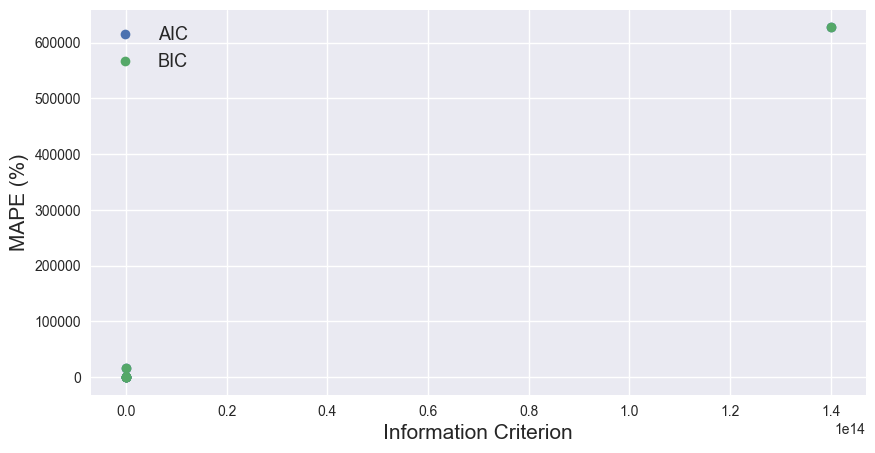

In [64]:
fig=plt.figure(figsize=(10,5))
plt.plot(res['AIC'],res['MAPE'],'o')
plt.plot(res['BIC'],res['MAPE'],'o')
plt.xlabel('Information Criterion',fontsize=15)
plt.ylabel('MAPE (%)',fontsize=15)
plt.legend(['AIC','BIC'],fontsize=13)
plt.show()

- We can notice that, for 'MAPE' it is least when 'AIC' and 'BIC' are at their max, in this case.


#### Fitting the VARMAX model with resulted parameters

In [65]:
model=VARMAX(train_set[pred].values,order=(p,q),enforce_stationarity=True)
model_fit=model.fit(disp=False)

In [66]:
#print(model_fit.summary())

### Predicting Timeseries on Train Set
----

In [67]:
predict = model_fit.get_prediction(start=0, end=len(train_set)-1)
predictions = predict.predicted_mean
idx = pd.date_range(start="2019-04-07",periods=110,freq='W')
df_predictions = pd.DataFrame(predictions[:,0],index=train_set.index,columns=[y+'_pred'])

In [68]:
# This dataframe consists of prediction on train set by fitted model
df_predictions.shape

(110, 1)

In [69]:
# Here, I have stacked the Actual and Predicted values for given TimeSeries
p=pd.concat([train_set[[y]],df_predictions],axis=1,ignore_index=False)

In [70]:
p.shape,p.columns

((110, 2), Index(['12844067194_WW', '12844067194_WW_pred'], dtype='object'))

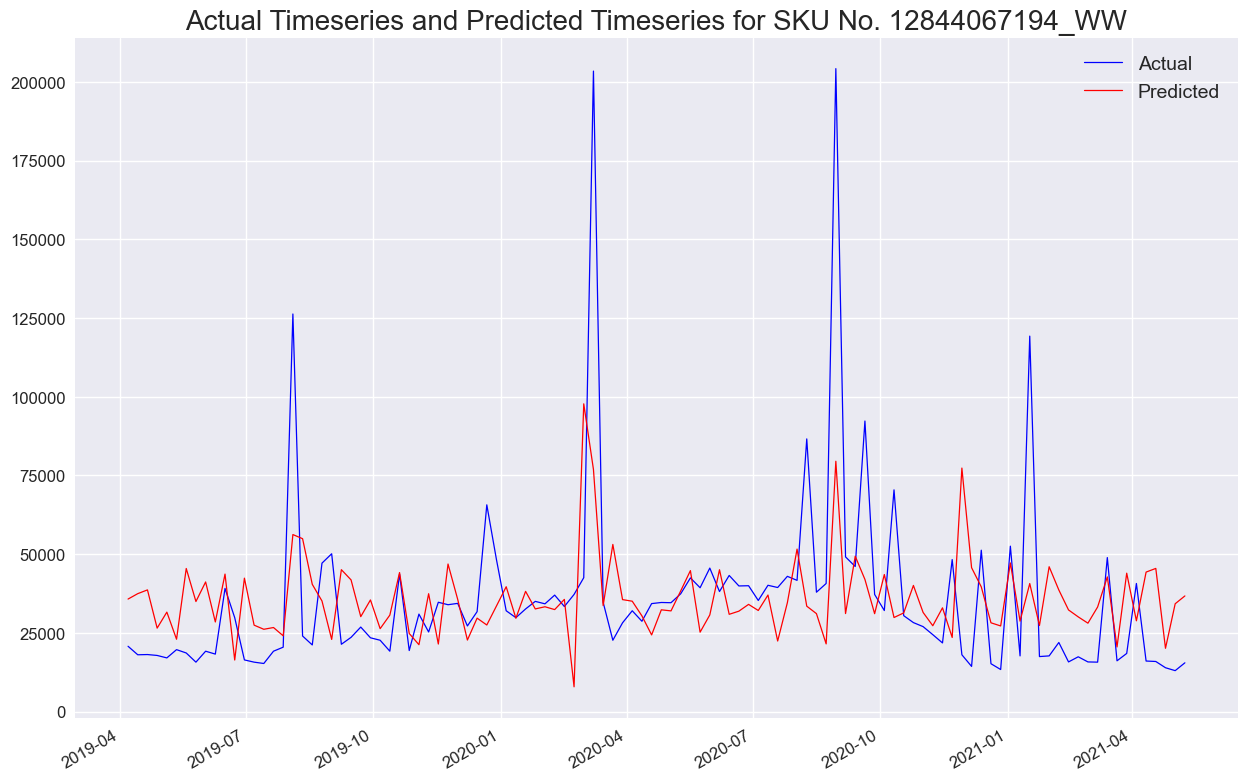

In [71]:
# Plotting the Predictions and Actual Values

y0=p[p.columns[0]]
y1=p[p.columns[1]]
x=date[:110]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,10))
ax.plot(x,y0,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y1,'-',color='red' ,linewidth=0.9)
ax.set_title("Actual Timeseries and Predicted Timeseries for SKU No. {}".format(y),fontsize=20)
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Predicted'],fontsize=14)
plt.show()

#### Diagonostic Checking
- The residuals should behave like white noise.
- The residual sample autocorrelation function should have no structure to identify.
    - Autocorrelation should not differ significantly from zero for all lags greater than one.

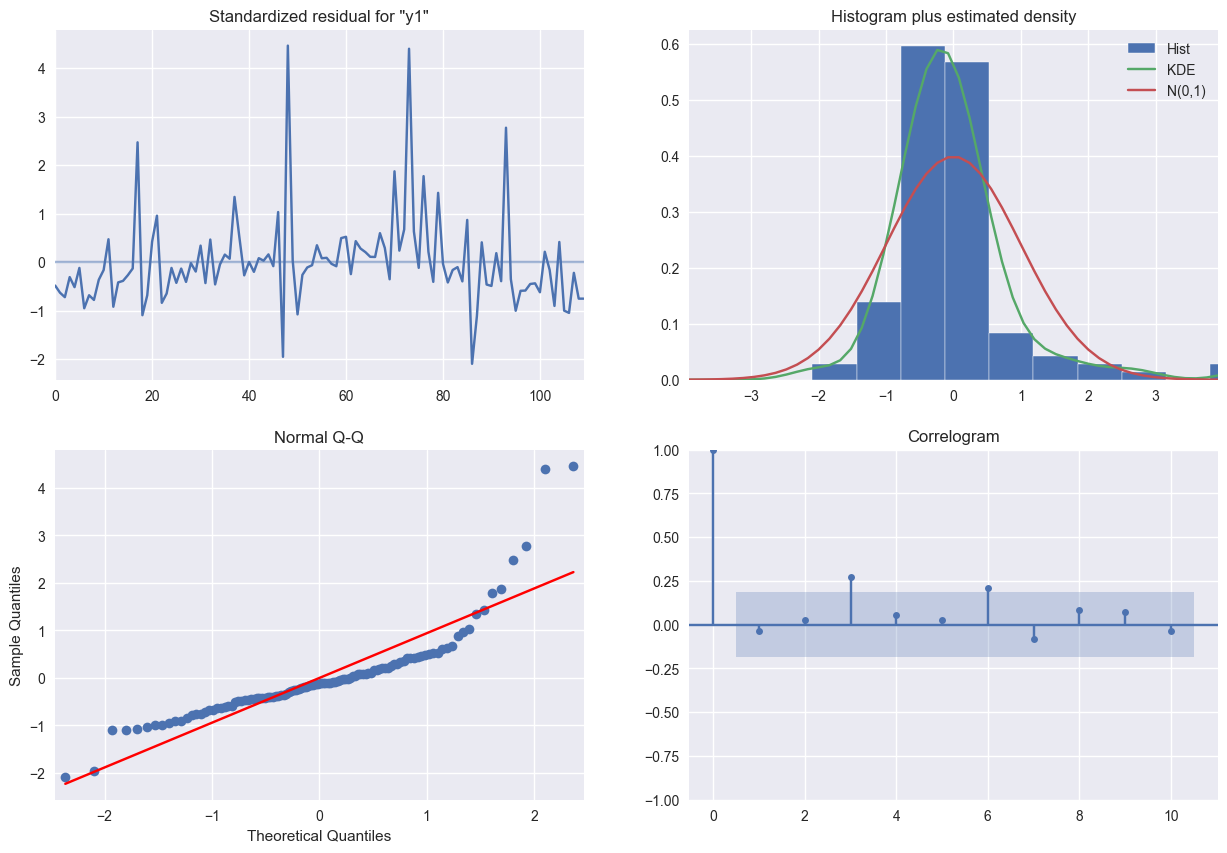

In [72]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.show()

#### Durbing Watson (Autocorrelation Test)
---
- The Durbin Watson statistic is a test for autocorrelation in a regression model's output.
- The DW statistic ranges from zero to four, with a value of 2.0 indicating zero autocorrelation.
    - Ideally, residuals shouldn't show any autocorrelation (2.0).
- Values below 2.0 mean there is positive autocorrelation and above 2.0 indicates negative autocorrelation.


In [73]:
from statsmodels.stats.stattools import durbin_watson

In [74]:
out = durbin_watson(model_fit.resid)
print("Autocorrelation of the Residuals for SKU: {} is {} ".format(y,round(out[0], 2)))


Autocorrelation of the Residuals for SKU: 12844067194_WW is 2.06 


### Error Metrics for Train Set
----
- Calculating MAPE, WAPE and TAPE
- Calculating mean value and RMSE.

In [75]:
print("For SKU: {} MAPE is : {}".format(item,MAPE(train_set[[y]].values.flatten(),df_predictions.values.flatten())))
print("For SKU: {} WAPE is : {}".format(item,WAPE(train_set[[y]].values.flatten(),df_predictions.values.flatten())*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(train_set[[y]].values.flatten(),df_predictions.values.flatten())*100))

For SKU: Automatic Mist Diffusers MAPE is : 55.93077212207679
For SKU: Automatic Mist Diffusers WAPE is : 55.93077212207679
For SKU: Automatic Mist Diffusers TAPE is : 47.476565351699314


In [76]:
rmse_item1=math.sqrt(mean_squared_error(train_set[[y]].values.flatten(),df_predictions.values.flatten()))
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(y,round(np.mean(train_set[[y]].values.flatten()),2),round(rmse_item1,2)))


Mean Volume Sales for SKU No. 12844067194_WW is : 35738.17.
Root Mean Squared Error is :26705.59


### Forecasting Timeseries on Test Set
----

In [77]:
# Generating forecasting

predict = model_fit.forecast(steps=8)
forecast = predict
idx = pd.date_range(start="2021-05-16",periods=8,freq='W')
df_forecast = pd.DataFrame(forecast[:,0],index=test_set.index,columns=[y+'_pred'])

In [78]:
# Stacking forecast and actual value in a dataframe
p=pd.concat([test_set[[y]],df_forecast],axis=1,ignore_index=False)

In [79]:
# Plotting the forecast and actual values

y0=train_set[[y]].append(test_set[[y]]).values
x=date
y1=p[p.columns[1]]
x1=date[110:]
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
ax[0].plot(x,y0,'-',color='blue' ,linewidth=0.9)
ax[0].plot(x1,y1,'-',color='red' ,linewidth=0.9)
ax[0].set_title("Actual Timeseries and Predicted Timeseries",fontsize=25)
ax[0].xaxis_date()     # interpret the x-axis values as dates
ax[0].tick_params(labelsize=15)
ax[0].legend(['Actual','Predicted'],fontsize=13)

ax[1].plot(x1,p[p.columns[0]],color='blue')
ax[1].plot(x1,p[p.columns[1]],color='red')
ax[1].set_title("Actual Timeseries and Forecasted Timeseries",fontsize=25)
ax[1].xaxis_date()     # interpret the x-axis values as dates
ax[1].tick_params(labelsize=15)
ax[1].legend(['Actual','Forecasted'],fontsize=13)
#fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
fig.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

### Error Metrics for Test Set
----
- Calculating MAPE, WAPE and TAPE
- Calculating mean value and RMSE.

In [ ]:
print("For SKU: {} MAPE is : {}".format(y,MAPE(test_set[[y]].values.flatten(),df_forecast.values.flatten())))
print("For SKU: {} WAPE is : {}".format(item,WAPE(test_set[[y]].values.flatten(),df_forecast.values.flatten())*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(test_set[[y]].values.flatten(),df_forecast.values.flatten())*100))


In [ ]:
rmse_item1=math.sqrt(mean_squared_error(test_set[[y]].values.flatten(),df_forecast.values.flatten()))
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(y,round(np.mean(train_set[[y]].values.flatten()),2),round(rmse_item1,2)))


--------